# Лабораторная работа №3

## Метод опорных векторов

Выполнила Карасева Екатерина M33351

### Данные

In [1]:
import pandas as pd

data = pd.read_csv('geyser.csv')

In [2]:
data['class'] = data['class'].apply(lambda x: 1. if x == 'P' else -1.)
data.head()

,x,y,class
0,1,4.4,-1.0
1,1,3.9,-1.0
2,1,4.0,1.0
3,1,4.0,-1.0
4,1,3.5,-1.0


In [3]:
import numpy as np


# нормализация
def min_max_normalize(arr):
    arr_min = np.min(arr)
    arr_max = np.max(arr)
    return arr.apply(lambda x: (x - arr_min) / (arr_max - arr_min) if arr_max - arr_min != 0 else 1.0)


def normalise(ds):
    for i in ds.columns:
        if i != 'class':
            ds[i] = min_max_normalize(ds[i])


normalise(data)
objects = data.drop(columns='class').to_numpy()
target = data['class'].to_numpy()
data.head()

,x,y,class
0,0.0,0.771429,-1.0
1,0.0,0.628571,-1.0
2,0.0,0.657143,1.0
3,0.0,0.657143,-1.0
4,0.0,0.514286,-1.0


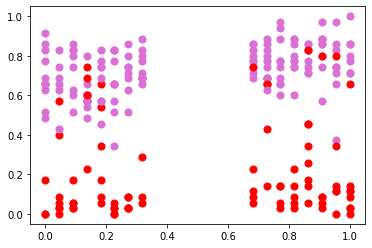

In [4]:
from matplotlib import pyplot as plt

dataset = data.to_numpy()
for i in range(len(dataset)):
    features = dataset[i][:-1]
    label = dataset[i][-1]
    c = 'orchid' if label == -1 else 'red'
    plt.scatter(features[0], features[1], color=c, s=50)
plt.show()

### Реализация алгоритма опорных векторов (встроенная подборка гиперпараметров)

In [12]:
def get_fun(x, y, kernel):
    def fun(alfa):
        summa = 0
        for i in range(0, len(alfa)):
            for j in range(0, len(alfa)):
                summa += alfa[i] * alfa[j] * y[i] * y[j] * kernel(x[i], x[j])
        return - np.sum(alfa) + 1 / 2 * summa

    return fun


def get_constraints(y):
    def fun(alfa):
        return np.sum(alfa * y)

    return fun


from scipy.optimize import minimize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from statistics import median


def svm(kernel):
    kf = KFold(n_splits=2, shuffle=True)
    C = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
    best_accuracy = -1.0
    best_c = 0.05
    for c in C:
        sum_accuracy = 0
        for train_ind, test_ind in kf.split(objects):
            train_x, test_x = objects[train_ind], objects[test_ind]
            train_y, test_y = target[train_ind], target[test_ind]
            train_n, train_m = train_x.shape
            alfa0 = [0] * train_n
            b = [(0, c)] * train_n
            res = minimize(get_fun(train_x, train_y, kernel), alfa0, bounds=b,
                           constraints={'type': 'eq', 'fun': get_constraints(train_y), 'jac': lambda l: train_y},
                           options={'maxiter': 40})
            cur_alfa = res.x
            cur_w0 = get_w0(cur_alfa, train_x, train_y, kernel)
            cur_classifier = get_classifier(cur_alfa, cur_w0, train_x, train_y, kernel)
            cur_accuracy = get_accuracy(cur_classifier, test_x, test_y)
            sum_accuracy += cur_accuracy
        if sum_accuracy / 2 > best_accuracy:
            best_accuracy = sum_accuracy / 2
            best_c = c
        print(best_c)
    return best_c, best_accuracy


def get_w0(alfa, x, y, kernel):
    n, m = x.shape
    w = [0] * m
    for i in range(0, n):
        w += alfa[i] * y[i] * x[i]
    w0 = []
    for i in range(0, n):
        if alfa[i] > 0 and np.abs(y[i] * kernel(w, x[i]) - 1) < 0.01:
            print('+ new w0')
            w0 = np.append(w0, kernel(w, x[i]) - y[i])
    return median(w0) if len(w0) > 0 else 0


def get_classifier(alfa, w0, x, y, kernel):
    n, m = x.shape

    def fun(test_x):
        summa = 0
        for i in range(0, n):
            summa += alfa[i] * y[i] * kernel(x[i], test_x)
        return np.sign(summa - w0)

    return fun


def get_accuracy(classifier, test_x, test_y):
    pred = []
    for x in test_x:
        pred = np.append(pred, classifier(x))
    return accuracy_score(test_y, pred, normalize=True)

### Линейное ядро

In [13]:
def get_classifier_with_params(c, kernel, x, y):
    n, m = x.shape
    alfa0 = [0] * n
    b = [(0, c)] * n
    res = minimize(get_fun(x, y, kernel), alfa0, bounds=b,
                   constraints={'type': 'eq', 'fun': get_constraints(y), 'jac': lambda l: y}, options={'maxiter': 60})
    alfa = res.x
    print('alfa = ' + str(alfa))
    w0 = get_w0(alfa, x, y, kernel)
    return get_classifier(alfa, w0, x, y, kernel)


linear_classifier = get_classifier_with_params(svm(np.dot)[0], np.dot, objects, target)
# linear_classifier = get_classifier_with_params(10.0, np.dot, objects, target)
print('classifier received')

0.05
+ new w0
+ new w0
+ new w0
0.1
0.1
0.1
5.0
5.0
50.0
50.0
alfa = [0.00000000e+00 4.97977089e-09 5.00000000e+01 3.31860154e-09
 5.00000000e+01 2.33382922e-09 3.74205804e+01 6.02479040e-11
 1.09781666e-10 4.56783544e-11 1.09804798e-10 4.92939467e-11
 5.00000000e+01 3.78744175e-10 1.12046508e-10 5.17232772e-09
 5.00000000e+01 5.00000000e+01 3.34138627e-09 1.23498882e-10
 2.52844703e-09 1.23412293e-10 5.00000000e+01 9.04323624e-11
 4.65371547e-11 0.00000000e+00 0.00000000e+00 4.80170827e-09
 5.86022321e-10 6.67629527e-01 5.54586426e-09 9.31329198e-11
 4.37924927e-11 1.22904776e-10 6.07996753e-11 1.22793423e-10
 4.38178129e-11 9.31124197e-11 5.00000000e+01 4.03537296e-09
 5.00000000e+01 5.00000000e+01 5.00000000e+01 5.00000000e+01
 8.64388796e-01 8.63942559e-01 8.63512514e-01 5.00000000e+01
 0.00000000e+00 5.00000000e+01 5.00000000e+01 5.00000000e+01
 5.00000000e+01 5.00000000e+01 1.92584431e-09 0.00000000e+00
 3.09160534e-09 9.78189040e-10 5.00000000e+01 1.59871056e-11
 9.78000226e-10 

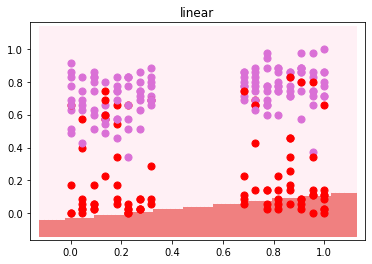

In [14]:
def draw_plot(title, ds, clf):
    plt.title(title)
    min_x1, max_x1 = np.min(ds[:, 0]), np.max(ds[:, 0])
    min_x2, max_x2 = np.min(ds[:, 1]), np.max(ds[:, 1])
    dx1 = max_x1 - min_x1
    dx2 = max_x2 - min_x2
    step1 = 10
    step2 = 60
    for x1 in np.arange(min_x1 - dx1 / step1, max_x1 + dx1 / step1, dx1 / step2):
        for x2 in np.arange(min_x2 - dx2 / step1, max_x2 + dx2 / step1, dx2 / step2):
            z = clf([x1, x2])
            c = 'w'
            c = 'lightcoral' if z == 1 else c
            c = 'lavenderblush' if z == -1 else c
            plt.scatter(x1, x2, color=c, s=150, marker='s')
    for i in range(len(ds)):
        features, label = ds[i][:-1], ds[i][-1]
        c = 'orchid' if label == -1 else 'red'
        plt.scatter(features[0], features[1], color=c, s=50)
    plt.show()


draw_plot('linear', dataset, linear_classifier)

alfa = [5.00000000e-01 5.00000000e-01 5.00000000e-01 5.00000000e-01
 5.00000000e-01 5.00000000e-01 5.00000000e-01 0.00000000e+00
 5.00000000e-01 0.00000000e+00 5.00000000e-01 1.28101894e-12
 5.00000000e-01 5.00000000e-01 5.00000000e-01 5.00000000e-01
 5.00000000e-01 5.00000000e-01 5.00000000e-01 5.00000000e-01
 5.00000000e-01 5.00000000e-01 5.00000000e-01 5.00000000e-01
 2.13100578e-13 5.00000000e-01 0.00000000e+00 5.00000000e-01
 5.00000000e-01 5.00000000e-01 5.00000000e-01 5.00000000e-01
 0.00000000e+00 5.00000000e-01 0.00000000e+00 5.00000000e-01
 0.00000000e+00 5.00000000e-01 5.00000000e-01 5.00000000e-01
 5.00000000e-01 5.00000000e-01 5.00000000e-01 5.00000000e-01
 5.00000000e-01 5.00000000e-01 5.00000000e-01 5.00000000e-01
 4.02256790e-13 5.00000000e-01 5.00000000e-01 5.00000000e-01
 5.00000000e-01 5.00000000e-01 5.00000000e-01 0.00000000e+00
 5.00000000e-01 5.00000000e-01 5.00000000e-01 5.00000000e-01
 5.00000000e-01 5.00000000e-01 0.00000000e+00 5.00000000e-01
 5.00000000e-01 5

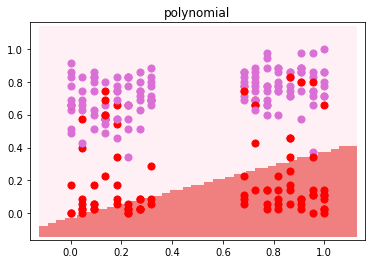

In [8]:
def polynomial_kernel(degree):
    def kernel(x, y):
        return np.dot(np.transpose(x), y) ** degree

    return kernel


def get_polynomial_classifier():
    best_accuracy = -1.0
    best_degree = 2
    best_c = 0.05
    D = [2, 3, 4, 5]
    for degree in D:
        c, accuracy = svm(polynomial_kernel(degree))
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_degree = degree
            best_c = c
        print('best_degree = ' + str(best_degree))
    print('polynomial params: c = ' + str(best_c) + ' d = ' + str(best_degree))
    return get_classifier_with_params(best_c, polynomial_kernel(best_degree), objects, target)


# polynomial_classifier = get_polynomial_classifier()
polynomial_classifier = get_classifier_with_params(0.5, polynomial_kernel(3), objects, target)
draw_plot('polynomial', dataset, polynomial_classifier)

alfa = [4.24530066e-02 1.00000000e-01 1.00000000e-01 1.00000000e-01
 1.00000000e-01 1.00000000e-01 1.00000000e-01 2.84879169e-14
 1.00000000e-01 3.68666618e-14 1.00000000e-01 2.27739811e-13
 1.00000000e-01 1.00000000e-01 1.00000000e-01 1.00000000e-01
 1.00000000e-01 1.00000000e-01 1.00000000e-01 1.00000000e-01
 1.00000000e-01 1.00000000e-01 1.00000000e-01 1.00000000e-01
 6.15162591e-14 1.00000000e-01 1.31246254e-13 1.00000000e-01
 5.24890766e-02 1.00000000e-01 1.00000000e-01 1.00000000e-01
 2.64982230e-14 1.00000000e-01 3.39688435e-14 1.00000000e-01
 2.81841167e-14 1.00000000e-01 1.00000000e-01 1.00000000e-01
 1.00000000e-01 1.00000000e-01 1.00000000e-01 1.00000000e-01
 1.00000000e-01 1.00000000e-01 1.00000000e-01 1.00000000e-01
 2.31400118e-14 1.00000000e-01 1.00000000e-01 1.00000000e-01
 1.00000000e-01 1.00000000e-01 1.00000000e-01 1.18127245e-13
 1.00000000e-01 2.12818634e-13 1.00000000e-01 1.00000000e-01
 2.15239417e-13 1.00000000e-01 3.32061276e-14 1.00000000e-01
 1.00000000e-01 1

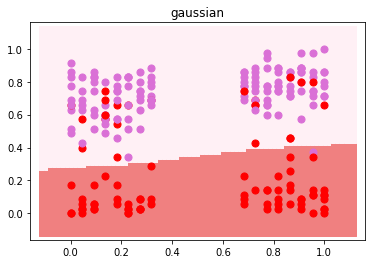

In [9]:
def gaussian_kernel(beta):
    def kernel(x, y):
        return np.exp(-beta * np.linalg.norm((x - y) ** 2))

    return kernel


def get_gaussian_classifier():
    best_accuracy = -1.0
    best_beta = 2
    best_c = 0.05
    B = [1, 2, 3, 4, 5]
    for beta in B:
        c, accuracy = svm(gaussian_kernel(beta))
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_beta = beta
            best_c = c
        print('best_beta = ' + str(best_beta))
    print('gaussian params: c = ' + str(best_c) + ' d = ' + str(best_beta))
    return get_classifier_with_params(best_c, gaussian_kernel(best_beta), objects, target)


# gaussian_classifier = get_gaussian_classifier()
gaussian_classifier = get_classifier_with_params(0.1, gaussian_kernel(1), objects, target)
draw_plot('gaussian', dataset, gaussian_classifier)